<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/IPA_T1_E4_JJTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Introducción al Aprendizaje Profundo
# José de Jesús Tapia López
# Tarea 1: Preceptrón y Redes Densas
# 19 de Marzo del 2021

## Ejercicio 4

4. Entrena una red completamente conectada para clasificación multiclase en el conjunto CIFAR10.

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# procesamiento de imágenes
from skimage import io
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

In [3]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

# CIFAR-10 classes
CLASSES = {0:'airplane',1:'car',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # desnormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal 
    ### SE LE AGREGÓ EL NÚMERO DE CANALES DE UNA
    ### IMAGEN EN RGB, EL CUAL ES 3
    x = x.reshape(*x.shape[:3],3)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=171299):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

In [4]:
# creamos el Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

Files already downloaded and verified


images[0] shape=(32, 32, 3) dtype=uint8


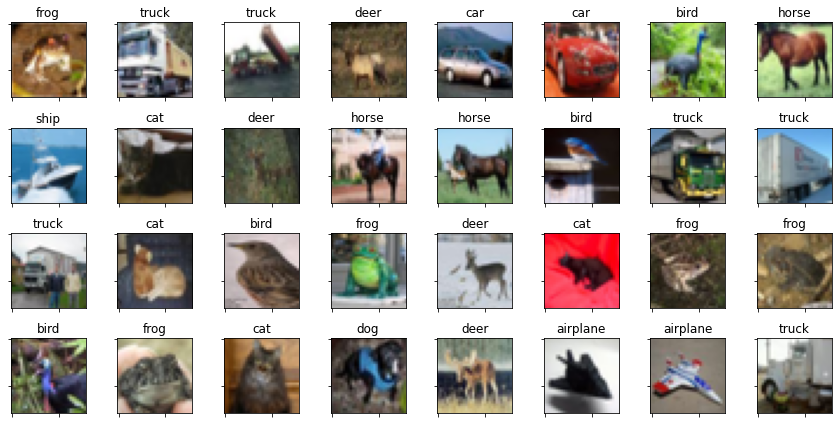

In [5]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [CLASSES[y] for y in labels]
display_grid(images, titles, ROWS, COLS)

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


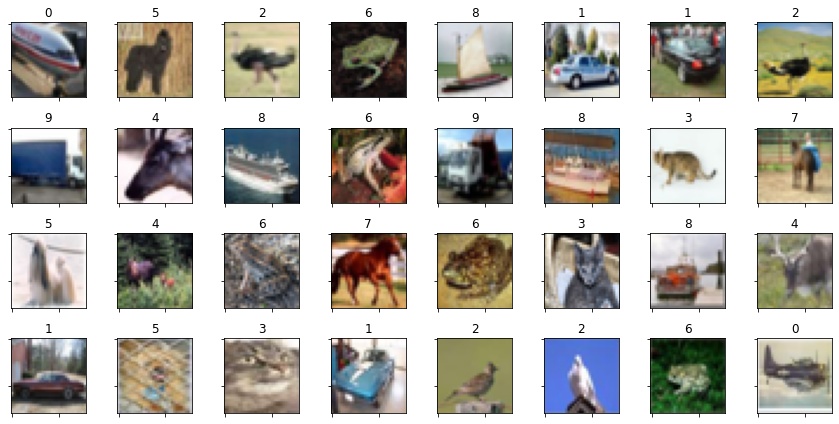

In [6]:
### Entrenamiento

# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


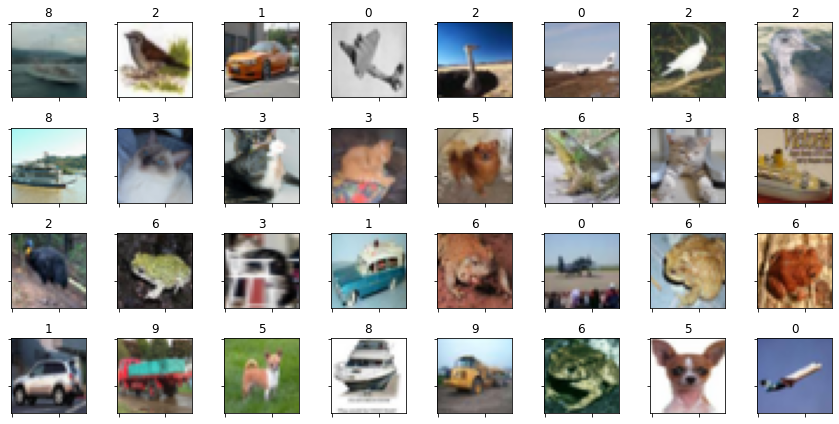

In [7]:
### Prueba

# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

Vamos a utilizar a la ReLU como función de activación, ya que al final del ejercicio se mostrará que tuvo un mejor rendimiento que con la sigmoide. 

In [8]:
### definición del modelo y la arquitectura

class FCN(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN, self).__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1, FC2, FC3, FC4 = 128, 10, 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 3x32x32] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2),
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 3x28x28]
        x = self.cls(x)
        
        return x

In [9]:
#instancia de la arquitectura

model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [10]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [11]:
# Inspección de la arquitectura

summary(model, (3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 10]                   --
|    └─Linear: 2-1                       [1, 128]                  393,344
|    └─ReLU: 2-2                         [1, 128]                  --
|    └─Linear: 2-3                       [1, 10]                   1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.58
Estimated Total Size (MB): 1.59

In [12]:
# Ciclo de entrenamiento supervisado.

def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Aunque por defecto se colocaron 20 épocas, las duplicamos para mejorar la exactitud, disminuir la pérdida y en consecuencia mejorar las predicciones.

In [14]:
# Entrenamos un modelo:

# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, epochs=40)


  2%|▎         | 1/40 [00:15<10:00, 15.40s/it]

E00 loss=[209.24,209.30] acc=[27.45,27.64]



  5%|▌         | 2/40 [00:30<09:44, 15.37s/it]

E01 loss=[199.07,199.08] acc=[30.26,30.76]



  8%|▊         | 3/40 [00:45<09:22, 15.20s/it]

E02 loss=[193.18,193.34] acc=[33.20,32.63]



 10%|█         | 4/40 [01:00<09:08, 15.24s/it]

E03 loss=[189.35,189.61] acc=[34.46,34.15]



 12%|█▎        | 5/40 [01:15<08:48, 15.09s/it]

E04 loss=[186.71,186.97] acc=[35.08,34.78]



 15%|█▌        | 6/40 [01:30<08:32, 15.08s/it]

E05 loss=[184.77,185.10] acc=[35.94,35.64]



 18%|█▊        | 7/40 [01:45<08:11, 14.89s/it]

E06 loss=[182.89,183.27] acc=[36.47,36.38]



 20%|██        | 8/40 [01:59<07:52, 14.77s/it]

E07 loss=[181.03,181.35] acc=[37.08,37.07]



 22%|██▎       | 9/40 [02:14<07:35, 14.70s/it]

E08 loss=[179.50,179.84] acc=[37.67,37.55]



 25%|██▌       | 10/40 [02:28<07:20, 14.67s/it]

E09 loss=[178.12,178.43] acc=[38.19,37.89]



 28%|██▊       | 11/40 [02:43<07:06, 14.70s/it]

E10 loss=[176.77,177.09] acc=[38.52,38.36]



 30%|███       | 12/40 [02:58<06:52, 14.73s/it]

E11 loss=[175.75,176.15] acc=[38.71,38.31]



 32%|███▎      | 13/40 [03:12<06:37, 14.72s/it]

E12 loss=[174.67,175.11] acc=[39.40,39.09]



 35%|███▌      | 14/40 [03:28<06:26, 14.86s/it]

E13 loss=[173.44,173.78] acc=[39.75,39.46]



 38%|███▊      | 15/40 [03:43<06:17, 15.09s/it]

E14 loss=[172.52,172.90] acc=[40.07,39.98]



 40%|████      | 16/40 [03:59<06:08, 15.34s/it]

E15 loss=[171.59,172.12] acc=[40.14,40.00]



 42%|████▎     | 17/40 [04:14<05:50, 15.24s/it]

E16 loss=[170.38,170.88] acc=[40.85,40.30]



 45%|████▌     | 18/40 [04:29<05:34, 15.20s/it]

E17 loss=[169.63,170.20] acc=[41.09,40.58]



 48%|████▊     | 19/40 [04:44<05:15, 15.02s/it]

E18 loss=[168.60,169.19] acc=[41.58,41.12]



 50%|█████     | 20/40 [04:59<05:00, 15.00s/it]

E19 loss=[167.74,168.44] acc=[41.75,41.50]



 52%|█████▎    | 21/40 [05:14<04:48, 15.18s/it]

E20 loss=[167.17,167.93] acc=[42.06,41.31]



 55%|█████▌    | 22/40 [05:30<04:32, 15.13s/it]

E21 loss=[166.44,167.26] acc=[42.23,41.59]



 57%|█████▊    | 23/40 [05:45<04:17, 15.17s/it]

E22 loss=[165.35,166.27] acc=[42.67,42.07]



 60%|██████    | 24/40 [06:00<04:01, 15.08s/it]

E23 loss=[164.38,165.41] acc=[43.03,42.20]



 62%|██████▎   | 25/40 [06:14<03:42, 14.81s/it]

E24 loss=[163.68,164.74] acc=[43.36,42.44]



 65%|██████▌   | 26/40 [06:28<03:25, 14.68s/it]

E25 loss=[163.13,164.20] acc=[43.54,42.71]



 68%|██████▊   | 27/40 [06:43<03:10, 14.64s/it]

E26 loss=[162.74,163.84] acc=[43.55,42.74]



 70%|███████   | 28/40 [06:57<02:54, 14.54s/it]

E27 loss=[161.54,162.82] acc=[44.10,43.08]



 72%|███████▎  | 29/40 [07:12<02:40, 14.57s/it]

E28 loss=[160.87,162.24] acc=[44.40,43.60]



 75%|███████▌  | 30/40 [07:26<02:25, 14.57s/it]

E29 loss=[160.28,161.67] acc=[44.61,43.82]



 78%|███████▊  | 31/40 [07:40<02:10, 14.46s/it]

E30 loss=[160.31,161.92] acc=[44.14,43.00]



 80%|████████  | 32/40 [07:55<01:56, 14.52s/it]

E31 loss=[159.25,160.81] acc=[44.69,43.78]



 82%|████████▎ | 33/40 [08:10<01:42, 14.71s/it]

E32 loss=[158.78,160.69] acc=[44.96,44.11]



 85%|████████▌ | 34/40 [08:25<01:27, 14.66s/it]

E33 loss=[157.91,159.62] acc=[45.37,44.33]



 88%|████████▊ | 35/40 [08:40<01:13, 14.71s/it]

E34 loss=[157.24,159.21] acc=[45.56,44.25]



 90%|█████████ | 36/40 [08:54<00:58, 14.73s/it]

E35 loss=[156.94,158.84] acc=[45.61,44.72]



 92%|█████████▎| 37/40 [09:09<00:44, 14.76s/it]

E36 loss=[156.51,158.69] acc=[45.81,44.80]



 95%|█████████▌| 38/40 [09:24<00:29, 14.90s/it]

E37 loss=[155.90,158.10] acc=[46.00,44.83]



 98%|█████████▊| 39/40 [09:40<00:14, 14.98s/it]

E38 loss=[155.21,157.48] acc=[46.37,45.07]



100%|██████████| 40/40 [09:55<00:00, 14.88s/it]

E39 loss=[155.01,157.44] acc=[46.14,45.10]


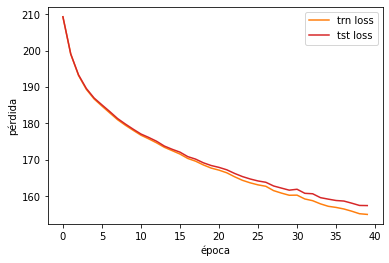

In [15]:
# Gráficas de pérdidas y exactitud

trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

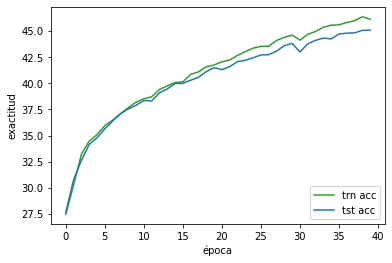

In [16]:


trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [17]:
# evaluación final

# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[155.01,157.43] acc=[46.14,45.09]


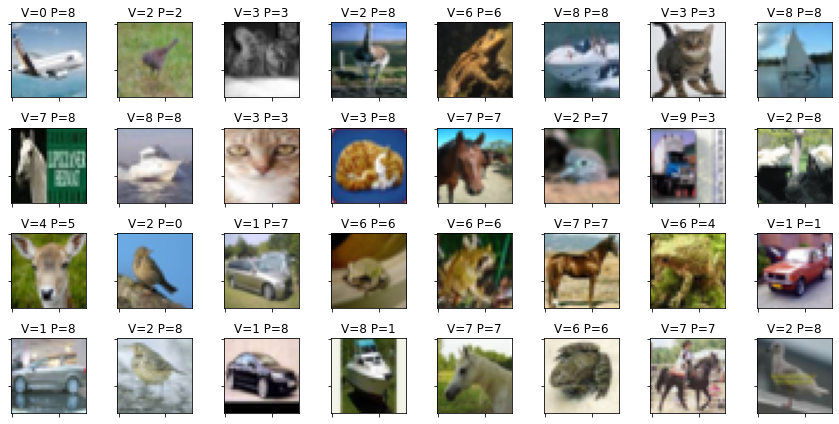

In [18]:
# inferencia

with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

### ¿Por qué se presentó la realización de este ejercicio usando una ReLU y se usaron más de 20 épocas?

En un principio se resolvió utilizando como función de activación a la Sigmoide (tal cual la misma arquitectura que se usó en clase para MNIST), obteniendo estos resultados de pérdida, accuracy y de predicción:

### Pérdida 

![Sigmoide1](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755067.jpg)

### Accuracy 

![Sigmoide2](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755068.jpg)

### Predicciones 

![Sigmoide3](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755069.jpg)


Posteriormente, siguiendo la misma arquitectura y únicamente modificando la función de activación a una ReLU, obtuvimos lo siguiente:

### Pérdida 

![ReLu1](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755064.jpg)

### Accuracy 

![ReLu2](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755065.jpg)

### Predicciones 

![ReLu3](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755066.jpg)


Como podemos observar en las imágenes anteriores, tenemos una mayor accuracy usando una ReLU que si usamos una Sigmoide, aunque aún así en ambas es muy baja; con aproximadamente 42% de exactitud en la ReLU y 34% en la Sigmoide; y una menor pérdida con la ReLU que con la sigmoide. Esto lo podemos verificar al realizar las predicciones, pues podemos observar que usando dichas funciones de activación, en ambas se predicen mal varias etiquetas. Usando la sigmoide, en la respectiva imagen notamos que se equivocó en 20 de 32 ($\frac{12}{32} = 37.5\%$ de exactitud en las predicciones); mientras que usando en la ReLU, vemos que se equivocó en 19 de 32 ($\frac{13}{32} = 40.625\%$ de exactitud en las predicciones)


Por ello, en este notebook se dejó a la ReLU y se colocaron 40 épocas. Nos damos cuenta que la pérdida  disminuyó y la exactitud subió a aproximadamente a 46%, y creo que no fue algo muy significativo, pues se tardó más de 12 minutos y la mejora fue poca. 

También intenté con el optimizador Adam (con función de activación ReLU), pero como que se sobreajustaba (a pesar de que sí mejoraba más la exactitud): 

### Pérdida 

![Adam1](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755084.jpg)

### Accuracy 

![Adam2](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/photo5080234837406755083.jpg)

Finalmente, igualmente intenté agregando más capas, siguiendo una arquitectura como esta:

![](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/IPA_T1_E3_9.PNG)

Sin embargo, no mejoró la exactitud ni disminuyó la pérdida:

![](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/IPA_T1_E3_7.PNG)


![](https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Figuras/T1/IPA_T1_E3_8.PNG)

Por lo tanto, creo que se mejoraría este ejercicio intentando con otras redes neuronales, como la CNN, porque con esta red se obtendría más información considerando regiones de la imagen y dado que las imágenes son en RGB (tres canales y no en uno, como en MNIST y en FashionMNIST).

